#### Импорт необходимых объектов

In [1]:
import os
import csv
import numpy as np
from scipy.interpolate import splrep, splev
import pickle

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Lars, LarsCV
from sklearn.linear_model import LassoLars, LassoLarsCV
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.linear_model import RidgeCV, LassoCV, LassoLarsCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import NuSVR, SVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor

import matplotlib.pyplot as plt

#### Функция чтения набора данных

In [2]:
def get_river_dataset(fname, pr_list=None, y_name='H_max'):
    pr_arr = []
    y_arr = []
    with open(fname, newline='') as f:
        reader = csv.DictReader(f, delimiter=';')
        for row in reader:
            pr_arr_row = []
            for pr in pr_list:
                pr_arr_row.append(row[pr])

            pr_arr.append(pr_arr_row)
            y_arr.append(row[y_name])
    X = np.asarray(pr_arr, dtype=np.float64)
    y = np.asarray(y_arr, dtype=np.float64)
    return X, y

#### Сумма, средний, высший, низший уровни

In [3]:
def get_sum(h_max):
    return np.sum(h_max)
    
def get_avg(h_max):
    return np.mean(h_max)
    
def get_max(h_max):
    return np.amax(h_max)
    
def get_min(h_max):
    return np.amin(h_max)

#### Среднеквадратическая погрешность прогноза S

In [4]:
def get_s(h_max, h_forecast):
    # Среднеквадратическая погрешность прогноза
    n = h_max.shape[0]
    sqr_diff = np.sum((h_max - h_forecast) ** 2) / (n - 1)
    std = sqr_diff ** 0.5
    return std    

#### Среднеквадратическое отклонение sigma

In [5]:
def get_sigma(h_max):
    # Среднеквадратическая погрешность климатическая.
    # Рассчитывается только по всей совокупности данных.
    return np.std(h_max, ddof=1)

#### Среднее значение максимальных уровней воды

In [6]:
def get_hmax_avg(h_max):
    # Среднее значение h_max.
    # Рассчитывается только по всей совокупности данных.
    return np.mean(h_max)

#### Допустимая погрешность прогноза delta_dop

In [7]:
def get_delta_dop(sigma):
    return 0.674 * sigma

#### Критерий критерий применимости и качества методики S/sigma

In [8]:
def get_criterion(s, sigma):
    return s / sigma

#### Климатическая обеспеченность Pk

In [9]:
def get_pk(h_max, h_max_avg, delta_dop):
    diff = np.abs(h_max - h_max_avg) / delta_dop
    trusted_values = diff[diff <= 1.0]
    m = trusted_values.shape[0]
    n = h_max.shape[0]
    return m / n * 100.00

#### Обеспеченность метода (оправдываемость) Pm

In [10]:
def get_pm(h_max, h_forecast, delta_dop):
    diff = np.abs(h_max - h_forecast) / delta_dop
    trusted_values = diff[diff <= 1.0]
    m = trusted_values.shape[0]
    n = h_max.shape[0]
    return m / n * 100.00

#### Корреляционное отношение

In [11]:
def get_correlation_ratio(criterion):
    c_1 = (1 - criterion ** 2)
    ro = c_1 ** 0.5 if c_1 > 0 else 0
    return ro

#### Вероятная ошибка прогноза S'

In [12]:
def get_forecast_error(s):
    return 0.674 * s

#### Ошибки климатического/природного прогноза для каждого года delta50

In [13]:
def get_delta50(h_max, delta_dop, h_max_avg=None, h_max_forecast=None):
    if h_max_forecast is None:
        # delta50 климатическая
        return (h_max - h_max_avg) / delta_dop
    else:
        # delta50 прогноза
        return (h_max - h_max_forecast) / delta_dop
  

#### Функция записи списка моделей с их характеристиками в csv файл

In [14]:
def write_dataset_csv(year, dataset, dataset_name, fieldnames, pr_group, mode='training'):
    if mode == 'estimation':
        dir_path = f'results/Estimation/{year}/{dataset_name}/group-{pr_group}/'
        file_name = f'{dataset_name}-гр{pr_group}-Оценка.csv'
    elif mode == 'training':
        dir_path = f'results/Models/{year}/'
        file_name = f'{dataset_name}-гр{pr_group}-Обучение.csv'
    elif mode == 'forecast':
        dir_path = f'results/Forecast/{year}/'
        file_name = f'{dataset_name}-гр{pr_group}-Прогноз.csv'
    else:
        ...
    
    with open(
        f'{dir_path}'
        f'{file_name}', 
        'w', newline='', encoding='utf-8'
    ) as csvfile:
        
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, 
                                delimiter=';', extrasaction='ignore')
        writer.writeheader()
        writer.writerows(dataset)


#### Функция записи результатов экспериментов в csv файл для процесса выбора моделей и параметров

In [15]:
def write_experiment_csv(year, dataset, fieldnames, filename):
    fpath = f'results/Estimation/{year}/{filename}.csv'
    with open(fpath, 'a', newline='') as csvfile: #, encoding='cp1251'
        
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, 
                                delimiter=';', extrasaction='ignore')
        fsize = os.stat(fpath).st_size
        if not fsize:
            writer.writeheader()
        writer.writerows(dataset)


#### Функция разделения набора данных на тренировочный и тестовый

In [16]:
def train_test_split(X, y, n_test, split=True):
    if split:   
        X_train = X[:-n_test].copy()
        y_train = y[:-n_test].copy()
        X_test = X[-n_test:].copy()
        y_test = y[-n_test:].copy()
    else:
        X_train = X.copy()
        y_train = y.copy()
        X_test = X.copy()
        y_test = y.copy()
    return X_train, y_train, X_test, y_test

#### Функция перемешивания данных

In [17]:
def shuffle_xy(X, y, shuffle=True):
    if shuffle:
        # Перемешивание данных
        Xy = np.column_stack((X, y))
        rng = np.random.default_rng(42)
        rng.shuffle(Xy)
        y_sh = Xy[:, -1]
        X_sh = Xy[:,:-1]
    else:
        y_sh = y.copy()
        X_sh = X.copy()
    return X_sh, y_sh

#### Функция формирования тестового набора данных с подстановкой нормированных значений

In [18]:
def test_norm(x, pr_list, norms):
    x_norm = np.copy(x)
    for col, pr in enumerate(pr_list):
        if pr in norms:
            x_norm[:, col:col+1] = norms[pr]
    return x_norm

#### Функция получения датасетов

In [19]:
def get_datasets():
    datasets = {
        #'Неман-Белица': 'Неман',
        #'Неман-Гродно': 'Неман',
        #'Неман-Мосты': 'Неман',
        #'Неман-Столбцы': 'Неман',

        'Вилия-Стешицы': 'Вилия',
        #'Вилия-Михалишки': 'Вилия',
    }
    return datasets

#### Функция получения списка предикторов по названию датасета

In [20]:
def get_predictors(dataset_name, group=None):

    datasets = get_datasets()   
    predictors_lists = {
        'Неман': (
            ['S_2802', 'Smax', 'H_2802', 'X', 'X1', 'X2', 'X3', 'Xs'],
            ['Smax', 'H_2802', 'X', 'X1', 'X3'],
            ['S_2802', 'H_2802', 'X2', 'X3', 'Xs'],
        ),
        'Вилия': (
            ['S_2802', 'Smax', 'H_2802', 'X', 'X1', 'X2', 'X3', 'Xs', 'L_max', 'L_2802', 'Q12', 'Q01', 'Q02', 'Y_sum'],
            ['Smax', 'H_2802', 'X', 'X1', 'X3', 'L_max', 'Y_sum'],
            ['S_2802', 'H_2802', 'X2', 'X3', 'Xs', 'L_2802', 'Y_sum'],
        )
    }
    result = predictors_lists[datasets[dataset_name]] if group is None else \
             predictors_lists[datasets[dataset_name]][group]
    return result
    

#### Функция получения нормированных значений предикторов

In [21]:
def get_norms(dataset_name):
    norms_list = {
        'Неман-Белица': {'X1': 46.0, 'X2':35.0},
        'Неман-Гродно': {'X1': 36.0, 'X2':26.0},
        'Неман-Мосты': {'X1': 40.0, 'X2':31.0},
        'Неман-Столбцы': {'X1': 43.0, 'X2':34.0},

        'Вилия-Стешицы': {'S_max': 67.0, 'X': 112.0, 'X1': 40.0, 'X2': 33.0, 'L_max': 60.0},
        'Вилия-Михалишки': {'S_max': 60.0, 'X': 116.0, 'X1': 46.0, 'X2': 37.0, 'L_max': 57.0},
    }
    return norms_list[dataset_name]

    

#### Функция получения аугментированных данных

In [22]:
def augment_data(x_data, y_data, aug_n, aug_pow=2, mirror=True, s=None):
    #print(x_data)
    data_len = len(y_data)
    
    x_points = np.linspace(0, data_len, data_len)
    
    x_splitted = np.hsplit(x_data, x_data.shape[1])
    #print(x_splitted)

    x_list = []
    for arr in x_splitted:
        x_spl = splrep(x_points, arr, k=aug_pow, s=s)
        x_points_n = np.linspace(0, data_len, aug_n)
        x_col_augmented = splev(x_points_n, x_spl)
        x_list.append(x_col_augmented)
    x_augmented = np.array(x_list).T

    y_points = np.linspace(0, data_len, data_len)
    y_spl = splrep(y_points, y_data, k=aug_pow, s=s)
    y_points_n = np.linspace(0, data_len, aug_n)
    y_augmented = splev(y_points_n, y_spl)
        
    
    x_aug_round = np.round(x_augmented, decimals=-1)
    y_aug_round = np.round(y_augmented, decimals=1)

    x_data_round = np.round(x_data, decimals=-1)
    y_data_round = np.round(y_data, decimals=1)
    
    
    mx = (x_aug_round[:, None] == x_data_round).all(-1).any(1)
    x_aug_clear = x_augmented[~mx].copy()
    y_aug_clear = y_augmented[~mx].copy()
    
    # my = np.in1d(y_aug_round, y_data_round)
    # x_aug_clear = x_aug_clear[~my]
    # y_aug_clear = y_aug_clear[~my]
    
    print('x_aug_clear.shape', x_aug_clear.shape)
    print('x_augmented.shape', x_augmented.shape)

    if mirror:
        x_mirror = np.mean(x_augmented) - x_augmented + np.mean(x_augmented)
        y_mirror = np.mean(y_augmented) - y_augmented + np.mean(y_augmented)
    
        x_result = np.vstack((x_aug_clear, x_mirror))
        y_result = np.hstack((y_aug_clear, y_mirror))
    else:
        x_result = x_aug_clear
        y_result = y_aug_clear
    
    if mirror:
        ...
        plt.plot(y_points, y_data, 'o', y_points_n, y_mirror)
        plt.plot(x_points, x_data[:, 0], 'x', x_points_n, x_mirror[:, 0])

    
    plt.plot(y_points, y_data, 'o', y_points_n, y_augmented)
    plt.plot(x_points, x_data[:, 0], 'x', x_points_n, x_augmented[:, 0])
    plt.show()

    
    
    points_aug_clear = np.linspace(0, y_points, len(y_aug_clear))

    
    
    # plt.plot(y_points, y_data, 'o', points_aug_clear, y_aug_clear)
    # plt.plot(x_points, x_data[:, 0], 'x', points_aug_clear, x_aug_clear[:, 0])
    # plt.show()

    x_result[x_result < 0] = 0
    y_result[y_result < 0] = 0
    
    return x_result, y_result

#### Функция получения трансформеров входных данных

In [23]:
def get_transformer(transformer, n_samples=10_000):
    scaler = (
        StandardScaler() if transformer == 'standard' else \
        MinMaxScaler() if transformer == 'minmax' else \
        MaxAbsScaler() if transformer == 'maxabs' else \
        RobustScaler() if transformer == 'robust' else \
        QuantileTransformer(output_distribution='uniform', n_quantiles=min(10_000, n_samples), random_state=0) if transformer == 'uniform' else \
        QuantileTransformer(output_distribution='normal', n_quantiles=min(10_000, n_samples), random_state=0) if transformer == 'normal' else \
        PowerTransformer(method='box-cox', standardize=False) if transformer == 'normal-bc' else \
        PowerTransformer(method='yeo-johnson', standardize=False) if transformer == 'normal-yj' else \
        PowerTransformer(method='box-cox', standardize=True) if transformer == 'normal-bc-st' else \
        PowerTransformer(method='yeo-johnson', standardize=True) if transformer == 'normal-yj-st' else \
        None
    )
    return scaler

#### Функция получения списка моделей регрессоров

In [24]:
def get_regressors_list():
    names = [
        # 'LinearRegression',
        
        # 'Ridge',
        # 'RidgeCV',
        
        # 'ElasticNetCV',
        
        # 'LassoCV',

        # 'LarsCV',
        
        # 'Lars1',
        # 'Lars2',
        # 'Lars3',
        # 'Lars4',
        # 'Lars5',
        # 'Lars6',
        # 'Lars7',
        # # 'Lars8',

        # 'LassoLarsCV',
        
        # 'OMPCV',
        # 'OMP1',
        # 'OMP2',
        # 'OMP3',
        # 'OMP4',
        # 'OMP5',
        # 'OMP6',
        'OMP7',
        # # 'OMP8',
        
        # 'BayesianRidge',
        # 'BayesianRidgeCV',
        # 'ARDRegression',
        #'ARDRegressionCV',
        # 'SGDRegressor', 
        # 'PassiveAggressiveRegressor',
        # # 'HuberRegressor',
        # 'HuberRegressorCV',
        # 'TheilSenRegressor',
        # # 'TheilSenRegressorCV',
        # 'QuantileRegressor',
        # # 'QuantileRegressorCV',
        
        
        'KNeighborsRegressor',
        # # # 'NuSVR',
        # # # 'SVR',
        # 'MLPRegressor',
        
        # 'RandomForestRegressor',
        # 'ExtraTreesRegressor',
        # 'HistGradientBoostingRegressor',
        # 'BaggingRegressor',
        # 'VotingRegressor',
        # 'StackingRegressorRidge',
        # 'AdaBoostRegressor',
    ]
    return names

#### Функция получения объектов моделей регрессии

In [25]:
def get_regressors_objects():
    # Инициализация генератора случайных чисел для
    # для обеспечения воспроизводимости результатов
    rng = np.random.RandomState(0)

    # Наборы гиперпараметров моделей для алгоритма кроссвалидации
    # Гиперпараметры для Ridge, Lasso, ElasticNet, LassoLars, HuberRegressor
    alphas = np.logspace(-4, 3, num=100)
    
    # Гиперпараметры для ElasticNet
    l1_ratio = np.linspace(0.01, 1.0, num=50)
    
    # Гиперпараметры для BayesianRidge
    alphas_init = np.linspace(0.5, 2, 5)
    lambdas_init = np.logspace(-3, 1, num=5)
    
    # Гиперпараметры для ARDRegression
    alphas_lambdas = np.logspace(-7, -4, num=4)
    
    # Гиперпараметры для SGDRegressor
    losses = ['squared_error', 'huber', 
              'epsilon_insensitive', 'squared_epsilon_insensitive']
    sgd_alphas = np.logspace(-4, 1, num=100)
   
    # Гиперпараметры для PassiveAggressiveRegressor
    cc = np.linspace(0.1, 1.5, 50)
    
    # Гиперпараметры для HuberRegressor
    epsilons = np.append(np.linspace(1.1, 2.0, 10), [1.35])
    
    # Гиперпараметры для TheilSenRegressor
    # n_subsamples = np.arange(15, 24)
    n_subsamples = (16, 24, 32)
    
    # Гиперпараметры для QuantileRegressor
    # q_alphas = np.linspace(0, 1, 5)
    q_alphas = (0.1, 1, 2)    
    
    regressors = [
        # LinearRegression(),
        
        # Ridge(random_state=0) if not grid_search else \
        # GridSearchCV(
        #     estimator=Ridge(random_state=0), 
        #     param_grid={"alpha": alphas}
        # ),
        # RidgeCV(),

        # ElasticNetCV(random_state=0),
        
        # LassoCV(max_iter=10000, n_alphas=300, random_state=0),  
        
        # LarsCV(),
        
        # Lars(n_nonzero_coefs=1, random_state=0),
        # Lars(n_nonzero_coefs=2, random_state=0),
        # Lars(n_nonzero_coefs=3, random_state=0),
        # Lars(n_nonzero_coefs=4, random_state=0),
        # Lars(n_nonzero_coefs=5, random_state=0),
        # Lars(n_nonzero_coefs=6, random_state=0),
        # Lars(n_nonzero_coefs=7, random_state=0),
        # # Lars(n_nonzero_coefs=8, random_state=0),

        # LassoLarsCV(max_iter=500, max_n_alphas=1000),

        # OrthogonalMatchingPursuitCV(n_jobs=-1),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=1),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=2),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=3),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=4),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=5),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=6),
        OrthogonalMatchingPursuit(n_nonzero_coefs=7),
        # # OrthogonalMatchingPursuit(n_nonzero_coefs=8),
        
        # BayesianRidge(),
        # BayesianRidge() if not grid_search else \
        # GridSearchCV(
        #     estimator=BayesianRidge(),
        #     param_grid={"alpha_init": alphas_init, "lambda_init": lambdas_init}, 
        #     n_jobs=-1
        # ),

        # ARDRegression(),
        # ARDRegression() if not grid_search else \
        # GridSearchCV(
        #     estimator=ARDRegression(), 
        #     param_grid={"alpha_1": alphas_lambdas, "alpha_2": alphas_lambdas,
        #                 "lambda_1": alphas_lambdas,"lambda_2": alphas_lambdas}, 
        #     n_jobs=-1
        # ),

        # SGDRegressor(random_state=0) if not grid_search else \
        # GridSearchCV(
        #     estimator=SGDRegressor(random_state=0), 
        #     param_grid={"loss": losses, "alpha": sgd_alphas}, 
        #     n_jobs=-1
        # ),

        # PassiveAggressiveRegressor(random_state=0) if not grid_search else \
        # GridSearchCV(
        #     estimator=PassiveAggressiveRegressor(random_state=0), 
        #     param_grid={"C": cc}, 
        #     n_jobs=-1, 
        #     cv=3
        # ),

        # # HuberRegressor(max_iter=1000),
        # HuberRegressor(max_iter=1000) if not grid_search else \
        # GridSearchCV(
        #     estimator=HuberRegressor(), 
        #     param_grid={"epsilon": epsilons, "alpha": alphas}, 
        #     n_jobs=-1 
        # ),

        # TheilSenRegressor(random_state=0, n_jobs=-1),
        # TheilSenRegressor(random_state=0, n_jobs=-1) if not grid_search else \
        # GridSearchCV(
        #     estimator=TheilSenRegressor(random_state=0, n_jobs=-1), 
        #     param_grid={"n_subsamples": n_subsamples}, 
        #     n_jobs=-1
        # ),

        # QuantileRegressor(),
        # QuantileRegressor() if not grid_search else \
        # GridSearchCV(
        #     estimator=QuantileRegressor(), 
        #     param_grid={"alpha": q_alphas}, 
        #     n_jobs=-1
        # ),
        
        
        
        KNeighborsRegressor(n_neighbors=10, metric='euclidean'),
        # NuSVR(C=5.0, nu=0.9, kernel='poly', degree=3),
        # SVR(C=5.0, epsilon=0.2, kernel='poly', degree=3),
        
        
        # MLPRegressor(
        #     hidden_layer_sizes=(3, ), 
        #     activation='identity', 
        #     max_iter=100000, 
        #     early_stopping=True, 
        #     learning_rate='constant',
        #     learning_rate_init=0.00025,
        #     batch_size=75,
        #     solver='adam',
        #     random_state=0
        # ),
       
        
        
        # RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0),
        # ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0),
        # HistGradientBoostingRegressor(max_iter=100, loss='absolute_error', max_leaf_nodes=None, min_samples_leaf=10, random_state=0),
        # BaggingRegressor(
        #     #KNeighborsRegressor(n_neighbors=20, metric='euclidean'),
        #     estimator=ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0), 
        #     max_samples=0.75, max_features=0.75, n_estimators=10, random_state=0
        # ),

        # VotingRegressor(
        #     estimators=[
        #         ('hgbr', HistGradientBoostingRegressor(max_iter=100, loss='absolute_error', max_leaf_nodes=None, min_samples_leaf=10, random_state=0)), 
        #         ('omp', ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0)), 
        #         ('knr', KNeighborsRegressor(n_neighbors=20, metric='euclidean')),
        #         ('rfr', RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)),
        #     ]
        # ),


        # StackingRegressor( # RidgeCV - final estimator
        #     estimators=[
        #         ('knr', KNeighborsRegressor(n_neighbors=10, metric='euclidean')),
        #         ('rfr', RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)),
        #         ('hgbr', HistGradientBoostingRegressor(max_iter=100, loss='absolute_error', max_leaf_nodes=None, min_samples_leaf=10, random_state=0)), 
        #         ('etr', ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0)),
        #         ('omp', OrthogonalMatchingPursuit(n_nonzero_coefs=5)),
        #     ],
        # ),

        # AdaBoostRegressor(estimator=KNeighborsRegressor(n_neighbors=5, metric='euclidean'), n_estimators=100, loss='linear', random_state=0),
        
    ]
    return regressors


#### Функция оценки и выбора моделей регрессии

In [26]:
def compare_models(year, pr_group, n_test=None, norms=True, aug_n=0, aug_pow=2, aug_mirror=False, grid_search=False, scaler_x=None, scaler_y=None, shuffle=True, verify=True, serial=True, top_best=None):
    
    ds_dir = f'data/{year}/Train'
    
    
   
    datasets = get_datasets()

    fieldnames = [
        'Predictors', 
        'Equations', 
        'Method', 
        'Criterion', 
        'Correlation', 
        'Pm',
        # 'R2',

        # 'Criterion_t', 
        # 'Correlation_t', 
        # 'Pm_t',
        # 'R2_t',

        # 'Group',
        # 'Augmentation',
        # 'Data size',
        # 'Normalization',
        # 'Equations',
    ]

    # Описание структуры данных переменной datasets_result
    # datasets_result = {
    #     "hydropost_0": [
    #         { model_row }
    #         { model_row }
    #     ],
    #     ...,
    #     "hydropost_n": [
    #         { model_row }
    #         { model_row }
    #     ],
    # }
    
    
    # Итерация по датасетам
    datasets_result = dict()
    for ds in datasets:
        result_list = []
        
        pr_list = get_predictors(ds, group=pr_group)
        
        X, y = get_river_dataset(f'{ds_dir}/{ds}.csv', pr_list=pr_list)

        # Проверочный набор данных (исходный)
        X_prior = X.copy()
        y_prior = y.copy()

        # Полный набор данных
        X_full = X.copy()
        y_full = y.copy()

        if aug_n:
            X_full, y_full = augment_data(X_full, y_full, aug_n, aug_pow=aug_pow, mirror=aug_mirror)
        
        if shuffle:
            X_full, y_full = shuffle_xy(X_full, y_full, shuffle=True)
        
        if n_test:
            X_train, y_train, X_test, y_test = train_test_split(X_full, y_full, n_test, split=True)

        print("SHAPES:")
        print("X_train.shape, y_train.shape", X_train.shape, y_train.shape)
        print("X_test.shape, y_test.shape", X_test.shape, y_test.shape)
        
        if norms:
            norms_data = get_norms(ds)
            # Подстановка норм в тестовый набор признаков
            X_test = test_norm(X_test, pr_list, norms_data)
            # Подстановка норм в исходный набор признаков
            X_prior = test_norm(X_prior, pr_list, norms_data)
            
        # print("X_test:")
        # print(X_test)
        # print("X_train:")
        # print(X_train)

        transformer_y = get_transformer(scaler_y, n_samples=y_train.shape[0]) # !!!
        transformer_x = get_transformer(scaler_x, n_samples=y_train.shape[0]) # !!!
        print(transformer_y)
        print(transformer_x)    
            
        # Список оцениваемых ререссионных моделей !!!!!
        names = get_regressors_list()
        regressors = get_regressors_objects()

        # Итерация по моделям регрессии
        for name, model in zip(names, regressors):

            # Препроцессинг - трансформация целевых значений y
            if scaler_y: 
                regressor = TransformedTargetRegressor(regressor=model, transformer=transformer_y)
            else:
                regressor = model
            
            
            one_model_row = dict()

            print('X_train.shape', X_train.shape)
            print('y_train.shape', y_train.shape)
            print('X_test.shape', X_test.shape)
            print('y_test.shape', y_test.shape)
            # n_samples = min(10000, y_train.shape[0]) ## Не нужно???

            # Препроцессинг - трансформация признаков X
            regr = make_pipeline(transformer_x, regressor) if transformer_x else regressor

            # Обучение моделей на тренировочном наборе данных
            regr.fit(X_train, y_train)
            try:
                regr.fit(X_train, y_train)
            except ValueError as error:
                print(error)
                continue
            if serial:
                serial_model = pickle.dumps(regr)
                regr = pickle.loads(serial_model)

            
            # Прогноз по тестовому набору 
            y_predicted_test = np.ravel(regr.predict(X_test))
            # Прогноз по исходному набору 
            y_predicted_prior = np.ravel(regr.predict(X_prior))

            print('Estimation')
            print(y_predicted_prior)
            
            # Очистка значений строк предикторов и уравнений перед переходом к следующей модели
            coef = None
            intercept = None
            
            try:
                coef = regr.best_estimator_.coef_
                intercept = regr.best_estimator_.intercept_
                
                if isinstance(intercept, np.ndarray):
                    intercept = intercept[0]
            except Exception as error:
                                
                try:
                    coef = regr.coef_
                    intercept = regr.intercept_
                
                    if isinstance(intercept, np.ndarray):
                        intercept = intercept[0]
                    print("ERROR1 START")
                    print(error)
                    print("ERROR1 FINISH")
                except Exception as error:
                    print("ERROR2 START")
                    print(error)
                    print("ERROR2 FINISH")
                
            
            try:
                # Коэффициенты уравнения (если есть)
                coef = np.around(np.ravel(coef), 3)
                intercept = round(intercept, 3)
                
                predictors_coef = {f: c for f, c 
                                   in zip(pr_list, coef) if c != 0.0}
                
                predictors = ", ".join(predictors_coef.keys())
                
                equation = (
                    str(intercept) 
                    + ' ' 
                    + ' '.join(str(c) + '*' 
                               + f for f, c in predictors_coef.items())
                )
                
                equation = equation.replace(" -", "-")
                equation = equation.replace(" ", " + ")
                equation = equation.replace("-", " - ")
    
                one_model_row['Predictors'] = predictors
                one_model_row['Equations'] = equation
            except Exception as error:
                print("ERROR3 START")
                print(error)
                print("ERROR3 FINISH")
                one_model_row['Predictors'] = ""
                one_model_row['Equations'] = ""

            # Название датасета
            one_model_row['Dataset_name'] = ds

            # Группа предикторов
            one_model_row['Group'] = pr_group
                
            # Название метода
            one_model_row['Method'] = name

            # Расчет показателей качества по методике

            # Сумма, максимум, минимум максимальных уровней
            # по исходному набору:
            one_model_row['H_sum'] = get_sum(y_prior)
            one_model_row['H_max'] = get_max(y_prior)
            one_model_row['H_min'] = get_min(y_prior)
            # по тестовому набору:
            one_model_row['H_sum_t'] = get_sum(y_test)
            one_model_row['H_max_t'] = get_max(y_test)
            one_model_row['H_min_t'] = get_min(y_test)
            
            # Среднее значение максимального уровня по всей выборке
            # по исходному набору:
            h_max_avg = get_hmax_avg(y_prior)
            one_model_row['H_avg'] = h_max_avg
            # по тестовому набору:
            h_max_avg_t = get_hmax_avg(y_test)
            one_model_row['H_avg_t'] = h_max_avg_t
            
            # Среднеквадратическое отклонение
            # по исходному набору:
            sigma = get_sigma(y_prior)
            one_model_row['Sigma'] = sigma
            # по тестовому набору:
            sigma_t = get_sigma(y_test)
            one_model_row['Sigma_t'] = sigma_t
            
            # Допустимая погрешность прогноза
            # по исходному набору:
            delta_dop = get_delta_dop(sigma)
            one_model_row['Delta_dop'] = delta_dop
            # по тестовому набору:
            delta_dop_t = get_delta_dop(sigma_t)
            one_model_row['Delta_dop_t'] = delta_dop_t
            
            # Обеспеченность климатическая Pk 
            # по исходному набору:
            pk = get_pk(y_prior, h_max_avg, delta_dop)
            one_model_row['Pk'] = pk
            # по тестовому набору:
            pk_t = get_pk(y_test, h_max_avg_t, delta_dop_t)
            one_model_row['Pk_t'] = pk_t

            # Обеспеченность метода (оправдываемость) Pm
            # по исходному набору:
            pm = get_pm(y_prior, y_predicted_prior, delta_dop)
            one_model_row['Pm'] = pm
            # по тестовому набору:
            pm_t = get_pm(y_test, y_predicted_test, delta_dop_t)
            one_model_row['Pm_t'] = pm_t

            # Среднеквадратическая погрешность прогноза
            # по исходному набору:
            s_forecast = get_s(y_prior, y_predicted_prior)
            one_model_row['S'] = s_forecast
            # по тестовому набору:
            s_forecast_t = get_s(y_test, y_predicted_test)
            one_model_row['S_t'] = s_forecast_t
            
            # Критерий эффективности метода прогнозирования 
            # климатический S/sigma
            # по исходному набору:
            criterion_forecast = get_criterion(s_forecast, sigma)
            one_model_row['Criterion'] = criterion_forecast
            # по тестовому набору:
            criterion_forecast_t = get_criterion(s_forecast_t, sigma_t)
            one_model_row['Criterion_t'] = criterion_forecast_t
            
            # Критерий эффективности метода прогнозирования 
            # климатический S/sigma в квадрате
            # по исходному набору:
            criterion_sqr = get_criterion(s_forecast, sigma) ** 2.0
            one_model_row['Criterion_sqr'] = criterion_sqr
            # по тестовому набору:
            criterion_sqr_t = get_criterion(s_forecast_t, sigma_t) ** 2.0
            one_model_row['Criterion_sqr_t'] = criterion_sqr_t

            
            # Корреляционное отношение ro
            # по исходному набору:
            correlation_forecast = get_correlation_ratio(criterion_forecast)
            one_model_row['Correlation'] = correlation_forecast
            # по тестовому набору:
            correlation_forecast_t = get_correlation_ratio(criterion_forecast_t)
            one_model_row['Correlation_t'] = correlation_forecast_t
            
            # Коэффициент детерминации R2
            # по исходному набору:
            one_model_row['R2'] = regr.score(X_prior, y_prior)
            # по тестовому набору:
            one_model_row['R2_t'] = regr.score(X_test, y_test)
            
            # Обученная модель
            one_model_row['Model'] = regr

            # Дополнительные поля для сравнения результатов экспериментов
            one_model_row['Group'] = pr_group
            one_model_row['Augmentation'] = f'Spline {aug_pow}' if aug_n > 0 else ''
            one_model_row['Aug-Mirror'] = f'Mirror' if aug_mirror > 0 else ''
            one_model_row['Data size'] = X_train.shape[0]
            one_model_row['X_scaling'] = scaler_x if scaler_x else ''
            one_model_row['Y_scaling'] = scaler_y if scaler_y else ''
            one_model_row['Equation'] = 'Yes' if one_model_row['Equations'] else ''
            one_model_row['Shuffle'] = 'Yes' if shuffle else ''
            
            # Добавление результатов модели в результирующий список по датасету
            result_list.append(one_model_row)
            

        # Сортировка результатов по каждому датасету
        result_list.sort(
            key=lambda row: (row['Criterion'], 
                             -row['Correlation'], 
                             -row['Pm'])
        )

        datasets_result[ds] = result_list

        # Запись в .csv файл
        write_dataset_csv(year, result_list, ds, fieldnames, pr_group=pr_group, mode='estimation')

        # Формирование проверочных прогнозов по исходным данным
        if verify:
            for i, rl in enumerate(result_list):
                if top_best is not None:
                    if i >= top_best:
                        break
                verify_forecast(year, ds, rl, i, pr_group=pr_group, n_test=n_test, norms=norms)

    return datasets_result

#### Функция формирования проверочных прогнозов и записи их в csv-файл

In [27]:
def verify_forecast(year, dataset_name, rl, num, pr_group, n_test=None, norms=True):

    ds_dir = f'data/{year}/Train'

    pr_list = get_predictors(dataset_name, group=pr_group)
    pr_list = ['year'] + pr_list
    
    fieldnames = [
        '№', 
        'Год',
        'Hmax фактический', 
        'Hф-Hср', 
        '(Hф-Hср)^2', 
        
        'δ50% Погрешность климатических прогнозов '
        'в долях от допустимой погрешности',
        
        'Hmax прогнозный', 
        'Hф-Hп', 
        '(Hф-Hп)^2', 
        
        'δ50% Погрешность проверочных прогнозов '
        'в долях от допустимой погрешности',
    ]

    X, y = get_river_dataset(
        f'{ds_dir}/{dataset_name}.csv', pr_list=pr_list, y_name='H_max'
    )

    X_test = X.copy()
    y_test = y.copy()
    
    if norms:
        norms = get_norms(dataset_name)
        X_test = test_norm(X_test, pr_list, norms)

    # Выделение первой колонки (года) из набора предикторов
    years = X_test[:, 0].copy()
    X_test = X_test[:, 1:].copy()
    
    # Forecast
    h_max_forecast = np.ravel(rl['Model'].predict(X_test))

    print('verify_forecast')
    print(h_max_forecast)
    
    # Hсредний
    h_max_avg = np.mean(y)

    # H - Hсредний
    diff_fact = y_test - h_max_avg

    # (H - Hсредний) в квадрате
    diff_fact_sqr = diff_fact ** 2

    # Погрешность климатических прогнозов в долях от допустимой погрешности
    delta_dop = get_delta_dop(get_sigma(y))
    error_climate = get_delta50(y_test, delta_dop, h_max_avg=h_max_avg)

    # H - Hпрогнозный
    diff_forecast = y_test - h_max_forecast

    # (H - Hпрогнозный) в квадрате
    diff_forecast_sqr = diff_forecast ** 2       

    # Погрешность проверочных прогнозов в долях от допустимой погрешности
    error_forecast = get_delta50(
        y_test, delta_dop, h_max_forecast=h_max_forecast
    )

    # Номер по порядку
    rows_num = y_test.shape[0]
    npp = np.arange(1, rows_num + 1, 1)

    # Конкатенация массивов
    att_tuple = (
        npp, 
        years, 
        y_test, 
        diff_fact, 
        diff_fact_sqr, 
        error_climate, 
        h_max_forecast, 
        diff_forecast, 
        diff_forecast_sqr, 
        error_forecast
    )
    
    arr = np.column_stack(att_tuple)
    arr = arr.tolist()

    # Обеспеченность метода (оправдываемость) Pm
    pm = get_pm(y_test, h_max_forecast, delta_dop)
    
    # Запись проверочного прогноза в csv файл
    with open(
        f'results/Estimation/{year}/{dataset_name}/group-{pr_group}/{dataset_name}'
        f'-проверочный-гр{pr_group}-{num:0>2}.csv', 
        'w', 
        newline='', 
        encoding='utf-8'
    ) as csvfile:
        
        stat_header = (
            f"Таблица  - "
            f"Проверочные прогнозы максимумов весеннего половодья\n"
            f"р.{rl['Dataset_name']}\n"
            f"Предикторы:;; {rl['Predictors']}\n"
            f"Уравнение:;; {rl['Equations']}\n"
            f"Модель:;; {rl['Method']}\n\n"
        )
        
        csvfile.write(stat_header)
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(fieldnames)
        writer.writerows(arr)
        
        stat_footer = (
            f"Сумма;;{rl['H_sum']}\n"  
            f"Средний;;{rl['H_avg']}\n" 
            f"Высший;;{rl['H_max']}\n"
            f"Низший;;{rl['H_min']}\n\n"
            
            f"σ = ;;{rl['Sigma']};;σ -;"
            f"среднеквадратическое отклонение (см)\n" 
            
            f"δдоп =;;{rl['Delta_dop']};;δдоп -;"
            f"допустимая погрешность прогноза (см)\n" 
            
            f"Pк =;;{rl['Pk']};;Pк -;"
            f"климатическая обеспеченность в %\n"
            
            f"Pм =;;{rl['Pm']};;Pм -;"
            f"обеспеченность метода в %\n"
            
            f"S =;;{rl['S']};;;"
            f"(допустимой погрешности проверочных прогнозов)\n"
            
            f"S/σ =;;{rl['Criterion']};;S -;"
            f"среднеквадратическая погрешность (см)\n" 
            
            f"(S/σ)^2 =;;{rl['Criterion_sqr']};;S/σ -;"
            f"критерий эффективности метода прогнозирования\n"
            
            f"ρ =;;{rl['Correlation']};;ρ -;"
            f"корреляционное отношение\n"
            
            f";;;;;(оценка эффективности метода прогнозирования)\n"
            f";;;;δ50% -;погрешность (ошибка) прогнозов (см)\n"
        )
        
        csvfile.write(stat_footer) 

#### Запуск процесса обучения моделей, формирования наборов уравнений множественной регрессии и проверочных прогнозов

x_aug_clear.shape (931, 14)
x_augmented.shape (1000, 14)


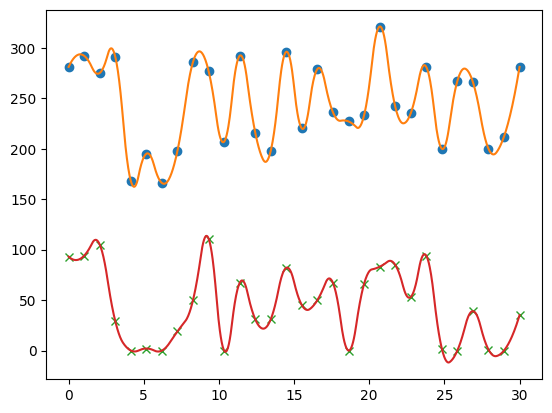

SHAPES:
X_train.shape, y_train.shape (831, 14) (831,)
X_test.shape, y_test.shape (100, 14) (100,)
None
QuantileTransformer(n_quantiles=831, output_distribution='normal',
                    random_state=0)
X_train.shape (831, 14)
y_train.shape (831,)
X_test.shape (100, 14)
y_test.shape (100,)
Estimation
[277.2168381  279.92053288 286.59951813 255.0372552  156.05585118
 249.34356949 195.02326362 198.96851544 263.73864412 284.25668683
 201.64604972 268.25003257 217.53110041 221.36997344 268.23557287
 236.2329547  274.71439104 233.66349239 190.61348606 232.59075956
 277.58779456 266.09550725 247.40345941 272.31604678 240.43379988
 243.28546273 254.33545514 236.927873   205.96820272 254.30963455]
ERROR2 START
'Pipeline' object has no attribute 'coef_'
ERROR2 FINISH
ERROR3 START
unsupported operand type(s) for *: 'NoneType' and 'float'
ERROR3 FINISH
X_train.shape (831, 14)
y_train.shape (831,)
X_test.shape (100, 14)
y_test.shape (100,)
Estimation
[285.36642708 288.58070204 275.35900213 260.

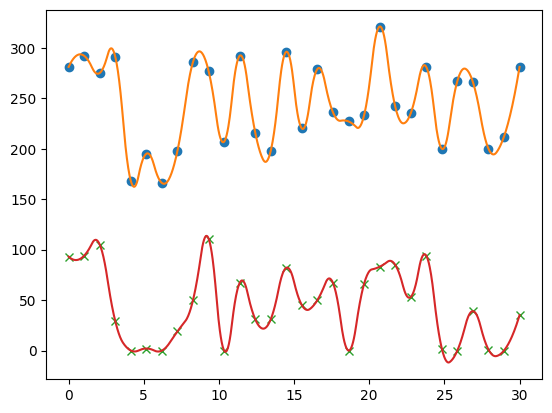

SHAPES:
X_train.shape, y_train.shape (831, 14) (831,)
X_test.shape, y_test.shape (100, 14) (100,)
QuantileTransformer(n_quantiles=831, output_distribution='normal',
                    random_state=0)
QuantileTransformer(n_quantiles=831, output_distribution='normal',
                    random_state=0)
X_train.shape (831, 14)
y_train.shape (831,)
X_test.shape (100, 14)
y_test.shape (100,)
Estimation
[279.27096293 287.26040968 286.55993724 257.76071228 164.65436244
 262.93141859 189.93757026 204.27643233 262.54415118 287.80632285
 200.90196496 278.00481932 210.18727801 227.79669584 270.75999505
 240.81530704 274.30804824 242.49336875 193.11799573 227.67018558
 290.45338289 271.69181367 251.31490503 277.98872876 240.74213619
 248.43593167 273.17885239 231.86172805 199.97171055 227.60665071]
ERROR2 START
'Pipeline' object has no attribute 'coef_'
ERROR2 FINISH
ERROR3 START
unsupported operand type(s) for *: 'NoneType' and 'float'
ERROR3 FINISH
X_train.shape (831, 14)
y_train.shape (831,)


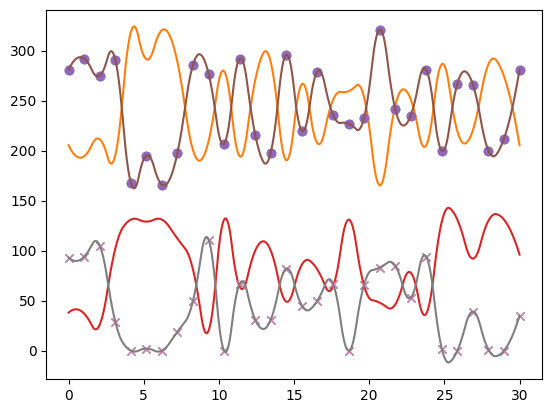

SHAPES:
X_train.shape, y_train.shape (1831, 14) (1831,)
X_test.shape, y_test.shape (100, 14) (100,)
None
QuantileTransformer(n_quantiles=1831, output_distribution='normal',
                    random_state=0)
X_train.shape (1831, 14)
y_train.shape (1831,)
X_test.shape (100, 14)
y_test.shape (100,)
Estimation
[276.09216307 280.94830926 276.03920296 257.64288167 128.00047616
 246.74086631 176.03928425 209.75761586 273.08082236 277.97052675
 181.50586352 270.86281746 224.23339227 216.92025091 257.72919255
 256.3711167  285.53643997 242.39415534 181.28991974 240.87581994
 286.8681967  257.92760305 242.9983089  284.9723446  233.33434583
 210.15626541 260.63014353 225.512927   183.33022871 236.01040547]
ERROR2 START
'Pipeline' object has no attribute 'coef_'
ERROR2 FINISH
ERROR3 START
unsupported operand type(s) for *: 'NoneType' and 'float'
ERROR3 FINISH
X_train.shape (1831, 14)
y_train.shape (1831,)
X_test.shape (100, 14)
y_test.shape (100,)
Estimation
[285.63033702 289.53933407 275.017201

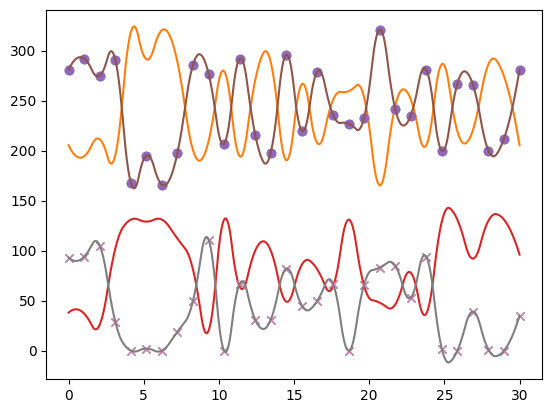

SHAPES:
X_train.shape, y_train.shape (1831, 14) (1831,)
X_test.shape, y_test.shape (100, 14) (100,)
QuantileTransformer(n_quantiles=1831, output_distribution='normal',
                    random_state=0)
QuantileTransformer(n_quantiles=1831, output_distribution='normal',
                    random_state=0)
X_train.shape (1831, 14)
y_train.shape (1831,)
X_test.shape (100, 14)
y_test.shape (100,)
Estimation
[277.35726086 280.203973   279.16280283 258.81449968 165.51011344
 249.2386658  191.52007357 207.05820259 270.44367917 281.93291094
 193.62807019 270.79161395 222.31311971 214.93104623 262.71807606
 258.48209969 284.07612221 245.63851498 194.27069805 240.77230894
 286.08908671 262.41473208 247.17189784 289.07572035 231.46252897
 216.06528561 264.89571916 226.65913213 197.00880493 227.57988034]
ERROR2 START
'Pipeline' object has no attribute 'coef_'
ERROR2 FINISH
ERROR3 START
unsupported operand type(s) for *: 'NoneType' and 'float'
ERROR3 FINISH
X_train.shape (1831, 14)
y_train.shape 

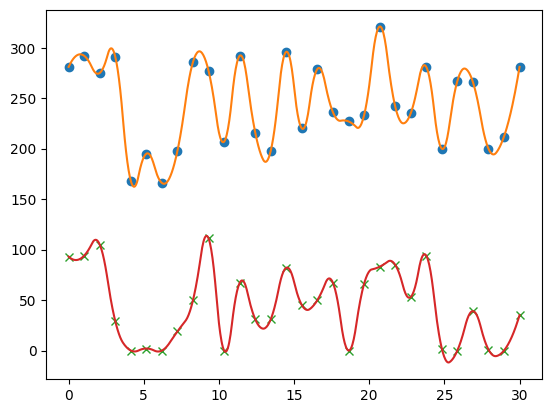

SHAPES:
X_train.shape, y_train.shape (558, 14) (558,)
X_test.shape, y_test.shape (100, 14) (100,)
None
QuantileTransformer(n_quantiles=558, output_distribution='normal',
                    random_state=0)
X_train.shape (558, 14)
y_train.shape (558,)
X_test.shape (100, 14)
y_test.shape (100,)
Estimation
[273.13293422 281.68769128 284.63295198 252.12526681 150.10149682
 254.19054849 193.05434536 204.5073945  255.12900219 286.4532087
 204.25870854 269.37731286 214.3131939  226.47818304 263.659317
 238.77220193 267.86214405 243.74531928 196.25307267 230.83524328
 286.81403146 263.93711488 249.87552121 268.02004652 241.23498104
 244.51648742 262.67226572 237.46781789 207.9421052  231.21815642]
ERROR2 START
'Pipeline' object has no attribute 'coef_'
ERROR2 FINISH
ERROR3 START
unsupported operand type(s) for *: 'NoneType' and 'float'
ERROR3 FINISH
X_train.shape (558, 14)
y_train.shape (558,)
X_test.shape (100, 14)
y_test.shape (100,)
Estimation
[285.53876197 289.52912293 276.69703245 266.085

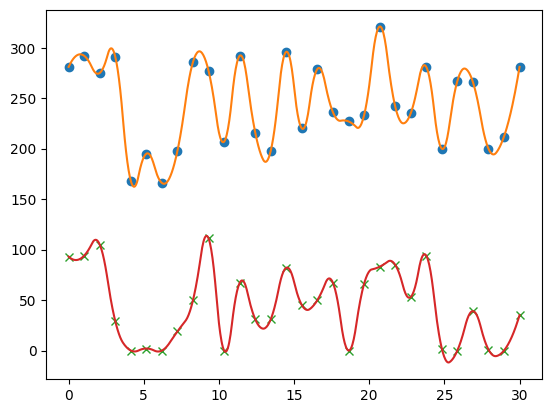

SHAPES:
X_train.shape, y_train.shape (558, 14) (558,)
X_test.shape, y_test.shape (100, 14) (100,)
QuantileTransformer(n_quantiles=558, output_distribution='normal',
                    random_state=0)
QuantileTransformer(n_quantiles=558, output_distribution='normal',
                    random_state=0)
X_train.shape (558, 14)
y_train.shape (558,)
X_test.shape (100, 14)
y_test.shape (100,)
Estimation
[279.18220909 287.67341768 285.81189998 257.88681152 163.09942715
 263.98844438 187.03379127 206.88079811 262.78121484 289.27595804
 201.92080511 279.27323578 209.69047502 227.95886051 271.06168969
 242.1356748  272.87085213 242.74181113 190.1970026  226.97165353
 291.03275748 272.38423315 251.69755766 275.42534335 242.63097129
 245.72663548 273.65506912 232.30007901 197.32787431 226.92198427]
ERROR2 START
'Pipeline' object has no attribute 'coef_'
ERROR2 FINISH
ERROR3 START
unsupported operand type(s) for *: 'NoneType' and 'float'
ERROR3 FINISH
X_train.shape (558, 14)
y_train.shape (558,)


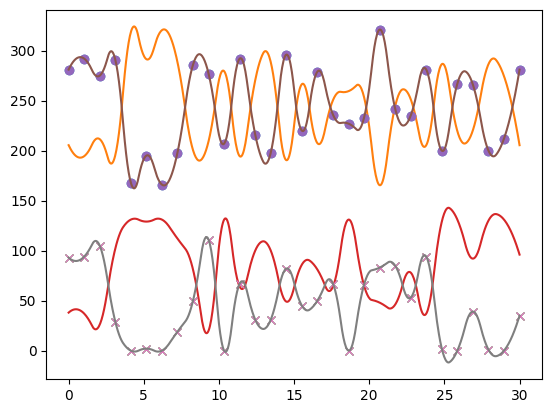

SHAPES:
X_train.shape, y_train.shape (1258, 14) (1258,)
X_test.shape, y_test.shape (100, 14) (100,)
None
QuantileTransformer(n_quantiles=1258, output_distribution='normal',
                    random_state=0)
X_train.shape (1258, 14)
y_train.shape (1258,)
X_test.shape (100, 14)
y_test.shape (100,)
Estimation
[273.78695194 277.12474104 277.23218003 257.92225312 150.20856664
 248.00132019 191.20797568 212.07384246 265.62067337 279.21561573
 195.9001347  265.47370733 227.08410814 224.12444131 258.51092017
 254.05675916 281.96663707 244.88676053 196.15041778 241.79800521
 282.65855501 259.39950423 246.32093072 283.97125446 236.05127078
 225.52172741 260.74125998 232.3212697  202.07041058 230.84093007]
ERROR2 START
'Pipeline' object has no attribute 'coef_'
ERROR2 FINISH
ERROR3 START
unsupported operand type(s) for *: 'NoneType' and 'float'
ERROR3 FINISH
X_train.shape (1258, 14)
y_train.shape (1258,)
X_test.shape (100, 14)
y_test.shape (100,)
Estimation
[286.44931938 290.92882849 276.355134

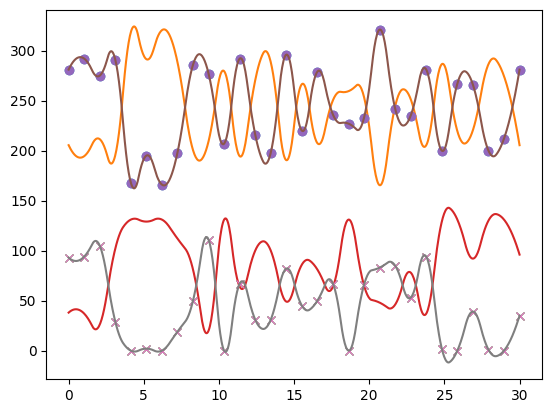

SHAPES:
X_train.shape, y_train.shape (1258, 14) (1258,)
X_test.shape, y_test.shape (100, 14) (100,)
QuantileTransformer(n_quantiles=1258, output_distribution='normal',
                    random_state=0)
QuantileTransformer(n_quantiles=1258, output_distribution='normal',
                    random_state=0)
X_train.shape (1258, 14)
y_train.shape (1258,)
X_test.shape (100, 14)
y_test.shape (100,)
Estimation
[277.67911569 280.07015551 279.19893107 259.24605838 165.47141686
 250.5227678  191.08346534 207.59292462 270.07973655 281.75744443
 193.62044018 271.10995636 223.01754973 215.10283257 262.61782393
 258.51700839 284.05584955 246.36961399 194.06727611 241.14920146
 285.91784824 262.73131562 247.68226082 285.44143716 231.99114992
 215.43744293 264.52416629 227.17161408 196.8475792  227.5305398 ]
ERROR2 START
'Pipeline' object has no attribute 'coef_'
ERROR2 FINISH
ERROR3 START
unsupported operand type(s) for *: 'NoneType' and 'float'
ERROR3 FINISH
X_train.shape (1258, 14)
y_train.shape 

In [28]:
###### top_best = None

exp_fieldnames = [
        'Dataset_name',
        'Group',
        'Method',
        'Criterion',
        'Correlation',
        'Pm',
        'R2',
        'Criterion_t',
        'Correlation_t',
        'Pm_t',
        'R2_t',
    
        
        'Augmentation',
        'Aug-Mirror',
        'Data size',
        'X_scaling',
        'Y_scaling',
        'Shuffle',
        'Equation',
        'Predictors',
    ]

experiments = [
    compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=1000, aug_pow=2, aug_mirror=False, grid_search=True, scaler_x='normal', scaler_y=None, shuffle=True, verify=True, serial=True),
    compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=1000, aug_pow=2, aug_mirror=False, grid_search=True, scaler_x='normal', scaler_y='normal', shuffle=True, verify=True, serial=True),
    compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=1000, aug_pow=2, aug_mirror=True, grid_search=True, scaler_x='normal', scaler_y=None, shuffle=True, verify=True, serial=True),
    compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=1000, aug_pow=2, aug_mirror=True, grid_search=True, scaler_x='normal', scaler_y='normal', shuffle=True, verify=True, serial=True),
    compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, aug_mirror=False, grid_search=True, scaler_x='normal', scaler_y=None, shuffle=True, verify=True, serial=True),
    compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, aug_mirror=False, grid_search=True, scaler_x='normal', scaler_y='normal', shuffle=True, verify=True, serial=True),
    compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, aug_mirror=True, grid_search=True, scaler_x='normal', scaler_y=None, shuffle=True, verify=True, serial=True),
    compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, aug_mirror=True, grid_search=True, scaler_x='normal', scaler_y='normal', shuffle=True, verify=True, serial=True),
    
    
    
    # compare_models(2024, pr_group=0, n_test=20_000, norms=True, aug_n=120_000, aug_pow=2, grid_search=True, scaler_x='normal', scaler_y='normal', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=20_000, norms=True, aug_n=120_000, aug_pow=2, grid_search=True, scaler_x='normal', scaler_y='standard', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=20_000, norms=True, aug_n=120_000, aug_pow=2, grid_search=True, scaler_x='normal-yj-st', scaler_y='normal-yj-st', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=20_000, norms=True, aug_n=120_000, aug_pow=2, grid_search=True, scaler_x='standard', scaler_y='standard', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=20_000, norms=True, aug_n=120_000, aug_pow=2, grid_search=True, scaler_x='standard', scaler_y='normal', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=20_000, norms=True, aug_n=120_000, aug_pow=2, grid_search=True, scaler_x='normal-yj-st', scaler_y=None, shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=20_000, norms=True, aug_n=120_000, aug_pow=2, grid_search=True, scaler_x='standard', scaler_y=None, shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=20_000, norms=True, aug_n=120_000, aug_pow=2, grid_search=True, scaler_x='normal', scaler_y=None, shuffle=True, verify=True, serial=True),

    # compare_models(2024, pr_group=0, n_test=2000, norms=True, aug_n=12000, aug_pow=2, grid_search=True, scaler_x='normal', scaler_y='normal', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=2000, norms=True, aug_n=12000, aug_pow=2, grid_search=True, scaler_x='normal', scaler_y='standard', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=2000, norms=True, aug_n=12000, aug_pow=2, grid_search=True, scaler_x='normal-yj-st', scaler_y='normal-yj-st', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=2000, norms=True, aug_n=12000, aug_pow=2, grid_search=True, scaler_x='standard', scaler_y='standard', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=2000, norms=True, aug_n=12000, aug_pow=2, grid_search=True, scaler_x='standard', scaler_y='normal', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=2000, norms=True, aug_n=12000, aug_pow=2, grid_search=True, scaler_x='normal-yj-st', scaler_y=None, shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=2000, norms=True, aug_n=12000, aug_pow=2, grid_search=True, scaler_x='standard', scaler_y=None, shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=2000, norms=True, aug_n=12000, aug_pow=2, grid_search=True, scaler_x='normal', scaler_y=None, shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=2000, norms=True, aug_n=12000, aug_pow=2, grid_search=True, scaler_x='normal-yj-st', scaler_y='standard', shuffle=True, verify=True, serial=True),

    # compare_models(2024, pr_group=0, n_test=2000, norms=True, aug_n=8000, aug_pow=2, grid_search=True, scaler_x='normal', scaler_y=None, shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=2000, norms=True, aug_n=7000, aug_pow=2, grid_search=True, scaler_x='normal', scaler_y='standard', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=2000, norms=True, aug_n=7000, aug_pow=2, grid_search=True, scaler_x='normal-yj-st', scaler_y='normal-yj-st', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=2000, norms=True, aug_n=7000, aug_pow=2, grid_search=True, scaler_x='standard', scaler_y='standard', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=2000, norms=True, aug_n=7000, aug_pow=2, grid_search=True, scaler_x='standard', scaler_y='normal', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=2000, norms=True, aug_n=7000, aug_pow=2, grid_search=True, scaler_x='normal-yj-st', scaler_y=None, shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=2000, norms=True, aug_n=7000, aug_pow=2, grid_search=True, scaler_x='standard', scaler_y=None, shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=2000, norms=True, aug_n=7000, aug_pow=2, grid_search=True, scaler_x='normal', scaler_y=None, shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=2000, norms=True, aug_n=7000, aug_pow=2, grid_search=True, scaler_x='normal-yj-st', scaler_y='standard', shuffle=True, verify=True, serial=True),
    
    
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='normal', scaler_y='normal', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='normal-yj-st', scaler_y='normal-yj-st', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='standard', scaler_y='standard', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='minmax', scaler_y='minmax', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='maxabs', scaler_y='maxabs', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='robust', scaler_y='robust', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='uniform', scaler_y='uniform', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='normal-yj', scaler_y='normal-yj', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='standard', scaler_y='normal', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='normal', scaler_y='standard', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='normal', scaler_y=None, shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='normal-yj-st', scaler_y=None, shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='standard', scaler_y=None, shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='minmax', scaler_y=None, shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='maxabs', scaler_y=None, shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='robust', scaler_y=None, shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='uniform', scaler_y=None, shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='normal-yj', scaler_y=None, shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='standard', scaler_y='robust', shuffle=True, verify=True, serial=True),
    # compare_models(2024, pr_group=0, n_test=100, norms=True, aug_n=700, aug_pow=2, grid_search=True, scaler_x='maxabs', scaler_y='normal', shuffle=True, verify=True, serial=True),

#     minmax
#    maxabs
#     robust
#     uniform
# normal-yj
]

exp_results = []
for ds in experiments:
    #print(ds)
    for k, v in ds.items():
        exp_results.extend(v)
        
exp_results.sort(
    key=lambda row: (row['Dataset_name'], -row['R2'])
)
write_experiment_csv(2024, exp_results, exp_fieldnames, 'experiment')

In [29]:
A = np.array(
    [[1.05000203, 2.7387801, 3.561009],
    [2.344563456, 4.6905623, 6.65879461243],
    [3.6784145, 5.56783465, 7.8907079098],
    [2.344563456, 4.6905623, 6.65879461243],
    [4.13531, 6.561234, 8.56782345]]
)

B = np.array(
    [
    [2.344563456, 4.6905623, 6.65879461243],
    [3.6784145, 5.56783465, 7.8907079098],
    ]
)

m = (A[:, None] == B).all(-1).any(1)

A[~m]

array([[1.05000203, 2.7387801 , 3.561009  ],
       [4.13531   , 6.561234  , 8.56782345]])

In [30]:
A = np.array([1, 2, 3, 4, 5])
A[~m]

array([1, 5])